In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet18-ciffar100/Restnet18_acc_76.09.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_75.75.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_75.83.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_75.90.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_76.08.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_76.03.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_76.26.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_76.40.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_75.92.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_75.81.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_75.82.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_75.80.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_77.17.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_75.79.pth
/kaggle/input/resnet18-ciffar100/Restnet18_acc_76.06.pth
/kaggle/input/resnet-cifar/net7.pth
/kaggle/input/resnet-cifar/net.pth
/kaggle/input/resnet-cifar/net12.pth
/kaggle/input/resnet-cifar/net3.pth
/

In [26]:
# LIBRARYs
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import argparse
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import auc,brier_score_loss
import pickle
from Utils.loading import *
from Utils.data_set import *

In [15]:
if torch.cuda.is_available():
    device = 'cuda'  
else:
    device = 'cpu'
print(device)

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

cuda


In [16]:
data_set = "Cifar100"

if data_set == "Cifar10":
    transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader, classes = cifar10()
elif data_set == "Cifar100":
    transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader= cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [17]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
# Define o criterion e o optimizer
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.2,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
def load_nets(n_nets):
    nets = list()
    for i in range(n_nets):
        if i == 0:
            i = ""
        nets.append(torch.load('../input/resnet-cifar/net{}.pth'.format(i)))
        if i == "":
            i = 0
    return nets

def load_nets2(folder):
    nets = list()
    for dirname, _, filenames in os.walk('/kaggle/input'):
        if dirname == "/kaggle/input/resnet18-ciffar100":
            for filename in filenames:
                nets.append(torch.load(dirname+"/"+filename))
    return nets
            
def caculate_outputs(nets, images):
    outputs = list()
    for i in range(len(nets)):
        nets[i].eval()
        outputs.append(nets[i](images))
    return outputs

def calculate_correct(predicted, labels):
    correct_aux = (predicted == labels.to("cuda")).sum().item()
    return round(1-correct_aux/10000,4)

def calculate_predicted(mean_list):
    uncs_max, predicted_aux = torch.max(mean_list.data, 1)
    uncs_var = torch.var(mean_list,dim=1)
    uncs_entr = torch.special.entr(mean_list)
    uncs_sum_entr = -torch.sum(uncs_entr, dim=-1)
    return uncs_max, uncs_var, uncs_sum_entr, predicted_aux

In [18]:
n_nets = 15
print("Loading Nets")
nets = load_cifar100(n_nets)
#nets = load_nets2("/kaggle/input/resnet18-ciffar100")
print("End")

Loading Nets
End


In [20]:
# Calcula a acuracia da rede
outputs = torch.tensor([]).to("cuda")

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to("cuda")
        outputs_0 = caculate_outputs(nets,images) # cria uma lista onde cada index é o resultado de uma das redes
        outputs_0 = torch.stack(tuple(outputs_0),dim=0) # transfor a lista em um tensor [15,100,10]
        
        outputs = torch.cat((outputs,outputs_0),dim=1) # junta os tensores na segunda dim ex: [15,100,10] -> [15,200,10]

In [21]:
outputs = torch.nn.functional.softmax(outputs, dim=-1)

# COBERTURA

In [22]:
outputs_mean = list()
for i in range(n_nets):
    outputs_mean.append(torch.mean(outputs[0:i+1],dim=0))
mean = torch.stack(tuple(outputs_mean),dim=0) # Junta as respostas

In [23]:
predict_list = list()
uncs_max_list = list()
uncs_var_list = list()
uncs_entr_list = list()
teste = list()
for i in range(n_nets):
    uncs_max, uncs_var, uncs_entr, predict = calculate_predicted(outputs_mean[i])
    predict_list.append(predict) # calcula a probabilidade de cada assemble
    uncs_max_list.append(uncs_max) # calcula a probabilidade de cada assemble
    uncs_var_list.append(torch.var(torch.mean(outputs[0:i+1],dim=-1),dim=0)) # calcula a probabilidade de cada assemble
    uncs_entr_list.append(uncs_entr)# calcula a probabilidade de cada assemble
    teste.append(uncs_var)

In [24]:
predict_cat = torch.stack(tuple(predict_list),dim=0) # Junta as respostas
uncs_max_cat = torch.stack(tuple(uncs_max_list),dim=0) # Junta as respostas
uncs_var_cat = torch.stack(tuple(uncs_var_list),dim=0) # Junta as respostas
uncs_entr_cat = torch.stack(tuple(uncs_entr_list),dim=0) # Junta as respostas
teste_var_cat = torch.stack(tuple(teste),dim=0) # Junta as respostas

In [27]:
def correct_class(y_pred,y_true):
    '''Returns a bool tensor indicating if each prediction is correct'''
    with torch.no_grad():
        #y_pred = torch.argmax(y_pred, -1) # não entendi para que serve
        correct = (y_pred==y_true)
    return correct

def correct_total(y_pred,y_true):
    '''Returns the number of correct predictions in a batch'''
    with torch.no_grad():
        correct = correct_class(y_pred,y_true)
        correct_total = torch.sum(correct).item()
    return correct_total


def get_n_biggest(vec,n):
    '''Returns the indexes of the N biggest values in vec'''
    if 0<n<1:
        n = int(n*vec.size(0))
    unc = torch.argsort(vec, descending = True)
    return unc[0:n]

def masked_coverage(y_pred,y_true, uncertainty, coverage):
    
    #dk_mask = unc_utils.dontknow_mask(uncertainty, coverage)
    #y_pred, y_true = torch.masked_select(y_pred,1-dk_mask),torch.masked_select(y_true,1-dk_mask)#apply_mask(y_pred,y_true,1-dk_mask)
    N = round((coverage)*uncertainty.shape[0])
    id = get_n_biggest(uncertainty,N)
    y_pred = y_pred[id]
    y_true = y_true[id]
    
    return y_pred,y_true

def acc_coverage(y_pred,y_true, uncertainty, coverage):
    '''Returns the total accuracy of model in some dataset excluding the 1-c most uncertain samples'''
    y_pred,y_true = masked_coverage(y_pred,y_true, uncertainty, coverage)
    acc = correct_total(y_pred,y_true)/y_true.size(0)
    return acc

def error_coverage(y_pred,y_true, uncertainty, coverage):
    '''Returns the 0-1 loss of model in some dataset excluding the 1-c most uncertain samples'''
    return 1-acc_coverage(y_pred,y_true, uncertainty, coverage)

def RC_curve(y_pred,y_true,uncertainty, risk = error_coverage, c_list = np.arange(0.05,1.05,0.05)):
    ''' Returns an array with the accuracy of the model in the data dataset
     excluding the most uncertain (total number set by the coverage) samples.
     Each item in the output array is the accuracy when the coverage is given by same item in c_list'''

    risk_list = np.array([])
    with torch.no_grad():
        for c in c_list:
            r = risk(y_pred,y_true, uncertainty, c)
            risk_list = np.append(risk_list,r)
    return risk_list

In [28]:
images_cat = torch.tensor([])
labels_cat = torch.tensor([])

for i, data in enumerate(testloader, 0):
        images, labels = data
        images_cat = torch.cat((images_cat,images),dim=0) # Junta as respostas
        labels_cat = torch.cat((labels_cat,labels),dim=0) # Junta as respostas

In [29]:
correct_list = list()
covarege_list1 = list()
covarege_list2 = list()
covarege_list3 = list()
for i in range(n_nets):
    correct_list.append(calculate_correct(predict_cat[i], labels_cat))
    covarege_list1.append(RC_curve(predict_cat[i],labels_cat.to("cuda"),uncs_max_cat[i]))
    covarege_list2.append(RC_curve(predict_cat[i],labels_cat.to("cuda"),uncs_var_cat[i]))
    covarege_list3.append(RC_curve(predict_cat[i],labels_cat.to("cuda"),uncs_entr_cat[i]))

In [30]:
def entropy(y):
        '''Returns the entropy of a probabilities tensor.'''
  
        entropy = torch.special.entr(y) #entropy element wise
        entropy = torch.sum(entropy,-1)

        return entropy

def mutual_info(pred_array):
    '''Returns de Mutual Information (Gal, 2016) of a ensemble
pred_array deve ser um tensor contendo os outputs (probabilidades) das T redes constituintes do Ensemble; Ou seja, deve ter shape (T,N,K), 
onde N é o número de pontos e K o número de classes do dataset. No caso de um Ensemble de 10 redes em todo o conjunto de teste do Cifar10, 
o shape será (10,10000,10)
'''
    ent = -entropy(torch.mean(pred_array, axis=0))
    MI = ent - torch.mean(entropy(pred_array), axis=0) 
    return MI

In [31]:
mean_list = list()
n_ensemble = list()

for i in range(n_nets):
    mean_list.append(torch.mean(outputs[0:i+1].cpu(),dim=0))
    n_ensemble.append(torch.stack(tuple(mean_list),dim=0)) # Junta as respostasA

In [32]:
mi_curves = list()
for i in range(n_nets):
    mi_curves.append(RC_curve(predict_cat[-1],labels_cat.to("cuda"),mutual_info(n_ensemble[i])))

# AUROC e AURC

In [33]:
def ROC_curve(output,y_true, uncertainty, return_threholds = False):
    if callable(uncertainty):
        uncertainty = uncertainty(output)
    y_true = np.logical_not(correct_class(output,y_true).cpu().numpy())
    fpr, tpr, thresholds = ROC(y_true,uncertainty.cpu().numpy())
    if return_threholds:
        return fpr,tpr,thresholds
    else:
        return fpr,tpr

def AURC(y_pred,y_true,uncertainty, risk = error_coverage, c_list = np.arange(0.05,1.05,0.05)):
    risk_list = RC_curve(y_pred,y_true,uncertainty, risk, c_list)
    return np.trapz(risk_list,x = c_list, axis = -1)

def AUROC(output,y_true,uncertainty):
    fpr,tpr = ROC_curve(output,y_true,uncertainty)
    return auc(fpr, tpr)

In [34]:
auroc = list()
aurc = list()

auroc_max  = list()
auroc_var  = list()
auroc_entr = list()

aurc_max  = list()
aurc_var  = list()
aurc_entr = list()

roc_curve1 = list()
roc_curve2 = list()


for i in range(n_nets):
    TPR, FPR = ROC_curve(predict_cat[i],labels_cat.to("cuda"),-uncs_max_cat[i])
    roc_curve1.append(TPR)
    roc_curve2.append(FPR)
    auroc_max.append(AUROC(predict_cat[i],labels_cat.to("cuda"),-uncs_max_cat[i]))
    if i > 0:
        auroc_var.append(AUROC(predict_cat[i],labels_cat.to("cuda"),-uncs_var_cat[i]))
        aurc_var.append(AURC(predict_cat[i],labels_cat.to("cuda"),-uncs_var_cat[i]))
    auroc_entr.append(AUROC(predict_cat[i],labels_cat.to("cuda"),-uncs_entr_cat[i]))
    aurc_max.append(AURC(predict_cat[i],labels_cat.to("cuda"),-uncs_max_cat[i])) 
    aurc_entr.append(AURC(predict_cat[i],labels_cat.to("cuda"),-uncs_entr_cat[i]))

auroc.append(auroc_max)
auroc.append(auroc_var)
auroc.append(auroc_entr)

aurc.append(aurc_max)
aurc.append(aurc_var)
aurc.append(aurc_entr)

In [35]:
import matplotlib
import matplotlib.pyplot as plt

# Plota 1 grafico
def plot_graph(X, Y, title = "", xlabel = "", ylabel = "", line = True):
    fig1 = plt.figure()
    fig1.set_size_inches(25.5, 15.5)
    ax1 = fig1.add_subplot()
    fig1.subplots_adjust(top=0.85)
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    if line == True:
        ax1.plot(X,Y)
    else:
        ax1.scatter(X,Y)
    pos1 = ax1.get_position()
    ax1.set_position([pos1.x0, pos1.y0, pos1.width * 0.9, pos1.height])
    ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.grid()
    fig1.set_size_inches(8.5, 5.5)
    return fig1

# Plota mais de um grafico para o mesmo X
def plot_mutiple_graph(X, Y, title = "", xlabel = "", ylabel = "", line = True, label = "{}", multi_label=False, n_graphs=n_nets):    
    if multi_label == True:
        label = label.replace(" ", "")
        label = label.split(",")
    fig1 = plt.figure()
    fig1.set_size_inches(25.5, 15.5)
    ax1 = fig1.add_subplot()
    fig1.subplots_adjust(top=0.85)
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    for i in range(n_graphs):
        if line == True:
            if multi_label == True:
                ax1.plot(X, Y[i], label=label[i])
            else:
                ax1.plot(X, Y[i], label=label.format(i+1))
        else:
            if multi_label == True:
                ax1.scatter(X, Y[i], label=label[i])
            else:
                ax1.scatter(X, Y[i], label=label.format(i+1))
    pos1 = ax1.get_position()
    ax1.set_position([pos1.x0, pos1.y0, pos1.width * 0.9, pos1.height])
    ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.grid()
    fig1.set_size_inches(8.5, 5.5)
    return fig1
    
# Plota mais de um grafico para diferentes X e Y
def plot_mutiple_graph2(X, Y, title = "", xlabel = "", ylabel = "", line = True, label = "{}", multi_label=False, n_graphs=n_nets):    
    if multi_label == True:
        label = label.replace(" ", "")
        label = label.split(",")
    fig1 = plt.figure()
    fig1.set_size_inches(25.5, 15.5)
    ax1 = fig1.add_subplot()
    fig1.subplots_adjust(top=0.85)
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    for i in range(n_graphs):
        if line == True:
            if multi_label == True:
                ax1.plot(X[i], Y[i], label=label[i])
            else:
                ax1.plot(X[i], Y[i], label=label.format(i+1))
        else:
            if multi_label == True:
                ax1.scatter(X[i], Y[i], label=label[i])
            else:
                ax1.scatter(X[i], Y[i], label=label.format(i+1))
    pos1 = ax1.get_position()
    ax1.set_position([pos1.x0, pos1.y0, pos1.width * 0.9, pos1.height])
    ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.grid()
    fig1.set_size_inches(8.5, 5.5)
    return fig1


# Plota mais de um grafico para o mesmo X
def plot_mutiple_graph3(X, Y, title = "", xlabel = "", ylabel = "", line = True, label = "{}", multi_label=False, n_graphs=n_nets):    
    if multi_label == True:
        label = label.replace(" ", "")
        label = label.split(",")
    fig1 = plt.figure()
    fig1.set_size_inches(25.5, 15.5)
    ax1 = fig1.add_subplot()
    fig1.subplots_adjust(top=0.85)
    ax1.set_title(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    for i in range(n_graphs):
        if i == 1:
            j = 1
        else:
            j = 0
        if line == True:
            if multi_label == True:
                ax1.plot(X[j:], Y[i], label=label[i])
            else:
                ax1.plot(X[j:], Y[i], label=label.format(i+1))
        else:
            if multi_label == True:
                ax1.scatter(X[j:], Y[i], label=label[i])
            else:
                ax1.scatter(X[j:], Y[i], label=label.format(i+1))
    pos1 = ax1.get_position()
    ax1.set_position([pos1.x0, pos1.y0, pos1.width * 0.9, pos1.height])
    ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.grid()
    fig1.set_size_inches(8.5, 5.5)
    return fig1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


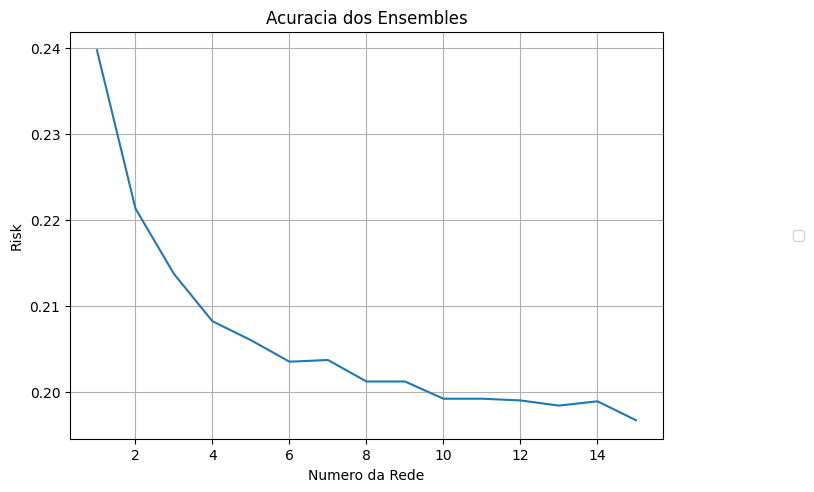

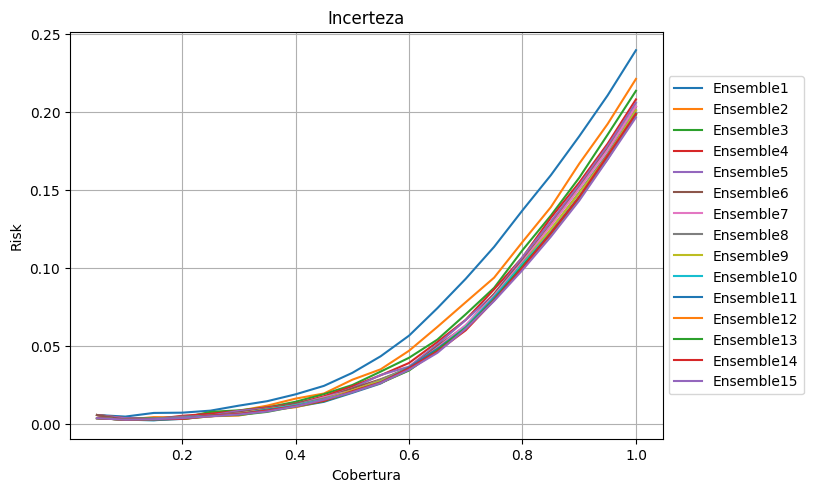

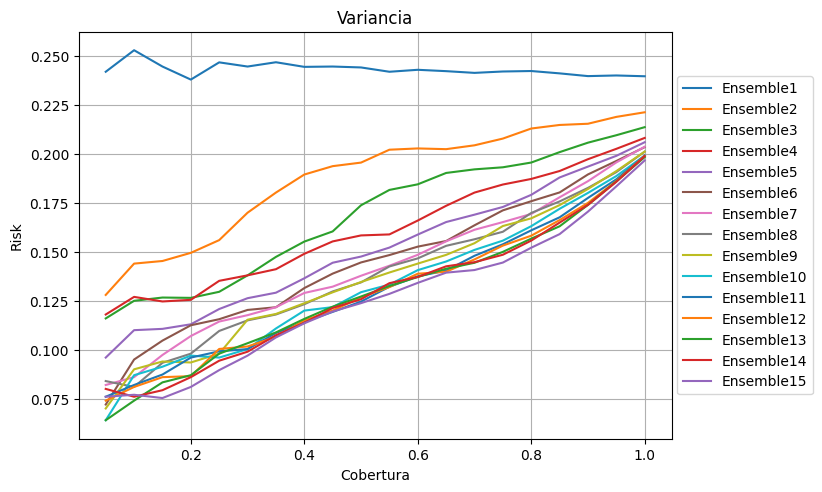

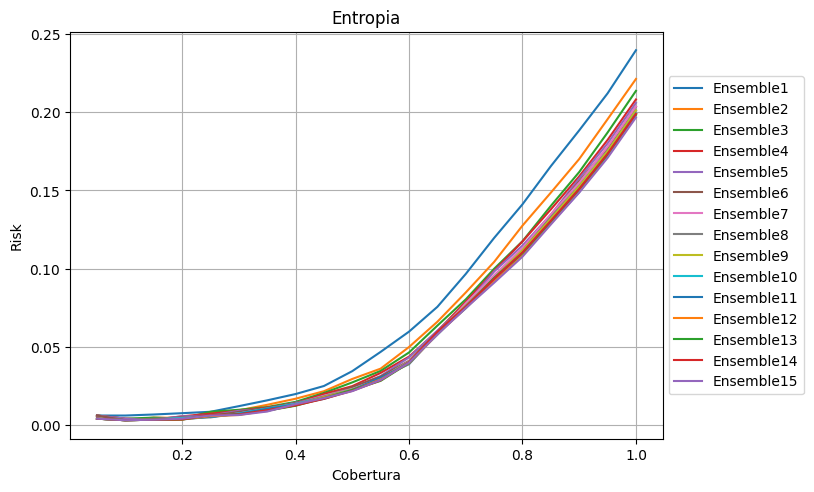

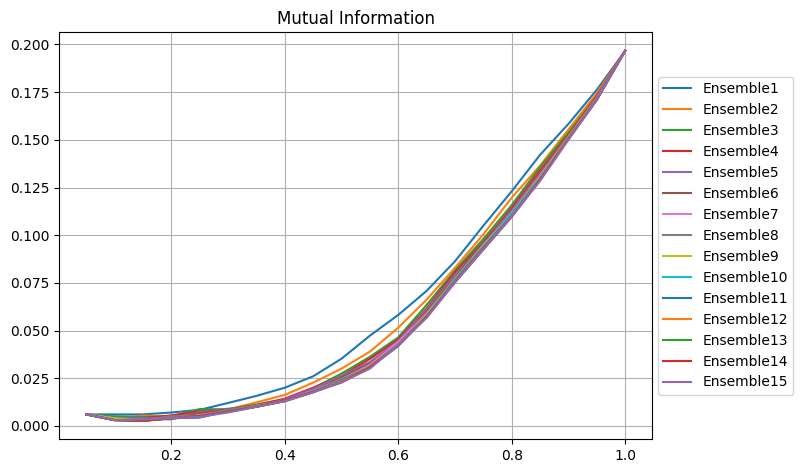

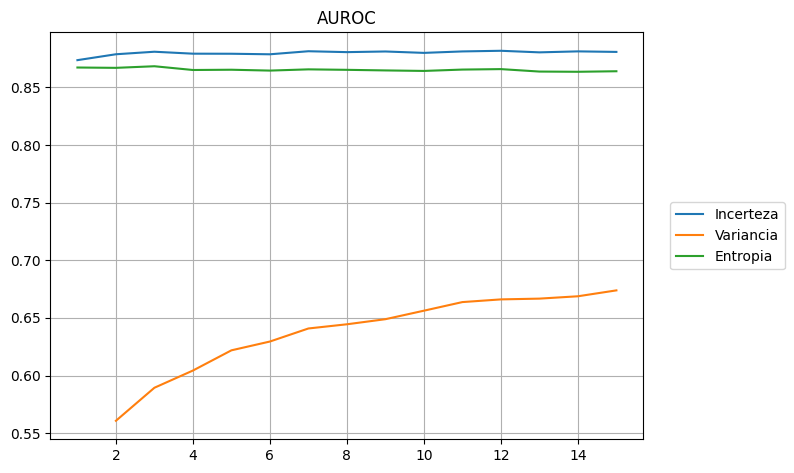

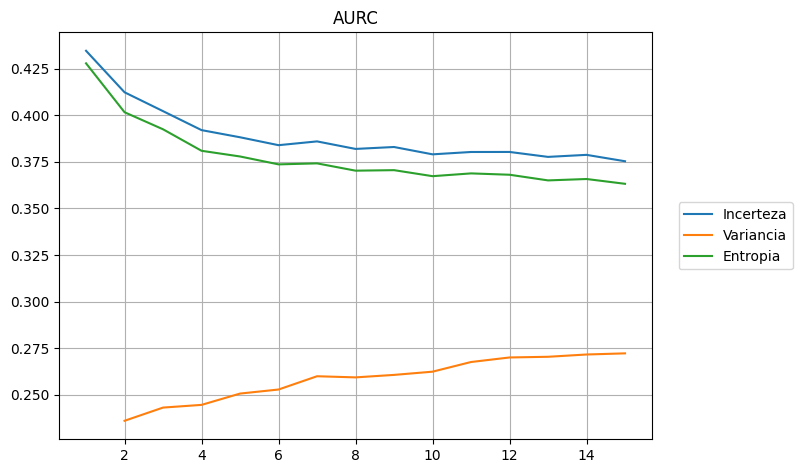

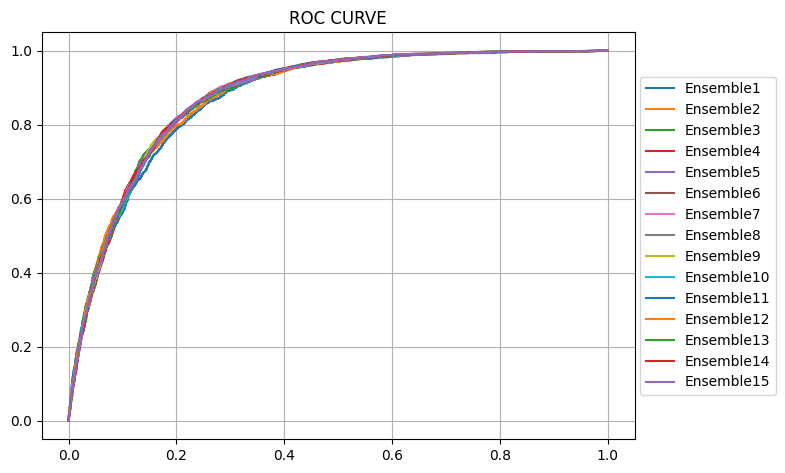

In [36]:
import matplotlib
import matplotlib.pyplot as plt

# Todosos graficos juntos
g1 = plot_graph(X = np.arange(1,16), Y = correct_list, title="Acuracia dos Ensembles", xlabel="Numero da Rede",ylabel="Risk")

g2 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=covarege_list1,title="Incerteza",xlabel="Cobertura",ylabel="Risk",label="Ensemble{}")

g3 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=covarege_list2,title="Variancia",xlabel="Cobertura",ylabel="Risk",label="Ensemble{}")

g4 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=covarege_list3,title="Entropia",xlabel="Cobertura",ylabel="Risk",label="Ensemble{}")

g5 = plot_mutiple_graph(X=np.arange(0.05,1.05,0.05),Y=mi_curves,title="Mutual Information",label="Ensemble{}")

g6 = plot_mutiple_graph3(X=np.arange(1,16),Y=auroc,title="AUROC",label="Incerteza,Variancia,Entropia",multi_label=True,n_graphs=3)

g7 = plot_mutiple_graph3(X=np.arange(1,16),Y=aurc,title="AURC",label="Incerteza,Variancia,Entropia",multi_label=True,n_graphs=3)

g8 = plot_mutiple_graph2(X=roc_curve1,Y=roc_curve2,title="ROC CURVE",label="Ensemble{}")

plt.show()

In [24]:
g1.savefig('Acuracia_ensemble.png')
g2.savefig('Incerteza.png')
g3.savefig('Variancia.png')
g4.savefig('Entropia.png')
g5.savefig('MI.png')
g6.savefig('AUROC.png')
g7.savefig('AURC.png')
g8.savefig('ROC_CURVE.png')

In [37]:
correct_list

[0.2397,
 0.2213,
 0.2137,
 0.2082,
 0.206,
 0.2035,
 0.2037,
 0.2012,
 0.2012,
 0.1992,
 0.1992,
 0.199,
 0.1984,
 0.1989,
 0.1967]

In [45]:
outputs[-1]

tensor([[1.2559e-04, 8.6246e-05, 4.4427e-05,  ..., 1.1162e-04, 2.1567e-04,
         2.9571e-05],
        [3.9848e-05, 1.7313e-04, 1.6705e-05,  ..., 1.3548e-04, 4.1023e-05,
         1.9397e-04],
        [2.0332e-05, 5.5618e-05, 1.1436e-03,  ..., 1.2460e-04, 1.6385e-04,
         1.6664e-04],
        ...,
        [2.2168e-05, 2.3258e-06, 3.4890e-08,  ..., 1.1479e-06, 4.1781e-08,
         3.7159e-06],
        [7.6335e-04, 3.3951e-03, 6.4242e-04,  ..., 1.3424e-02, 6.8120e-04,
         1.8937e-03],
        [2.3278e-05, 2.9069e-04, 1.0841e-04,  ..., 5.0247e-05, 1.3870e-05,
         3.7903e-05]], device='cuda:0')

In [43]:
area_sobre_curva = auc(np.arange(0.05,1.05,0.05), covarege_list1[-1])
print((1-correct_list[-1])*100, " ",area_sobre_curva)

80.33   0.04791259930257219


In [46]:
correct_list[-1]

0.1967